## The North Face e-commerce : boosting online sales !

### Librairies and imports

In [1]:
# Install spacy 
## -q is for "quiet". It removes logs 
!pip install spacy -q

In [2]:
import spacy
import re
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go

In [3]:
# Download english model 
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
# Import English using en_core_web_sm.load()
import en_core_web_sm
nlp = en_core_web_sm.load()

### Preprocessing of textual data

In [5]:
df = pd.read_csv("src/north_face_product_catalalog.csv")
df.head()

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

In [6]:
# Create a column with products name only
df["product"] = [x.split("-")[0] for x in df["description"]]
df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      product  
0      Active classic boxers   
1  Active sport boxer briefs   
2        Active sport briefs   
3         Alpine guide pants   
4            Alpine wind jkt

In [7]:
# Remove html elements 
df["clean_description"] = df["description"].apply(lambda x: re.sub("<[^<]+?>","",x))

# Remove ponctuation
df["clean_description"] = df["clean_description"].apply(lambda x: re.sub('[!\"#$%&()*+,-./:;<=>?@\[\]^_`{|}~\\\]+'," ", x)) 

# Keep only alpha numeric
df["clean_description"] = df["clean_description"].apply(lambda x: re.sub("[^0-9a-zA-Z]+", " ", x)) # replace all non alphanumerical char by a space

# Remove uppercase
df["clean_description"] = df["clean_description"].fillna('').apply(lambda x: x.lower())

df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      product  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                   clean_description  
0  active classic boxers there s a reason why our...  
1  active sport boxer briefs skinning up glory re...  
2  active sport briefs these superbreathable no f...  
3  alpine guide pants skin in climb ice switch to...  
4  alpine wind jkt on high ridges steep ice and a...

In [8]:
from spacy.lang.en.stop_words import STOP_WORDS

# Tokenization
df["desc_tokenized"] = df["clean_description"].fillna("").apply(lambda x: nlp(x))

# Remove stop words
df["desc_tokenized"] = df["desc_tokenized"].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])

df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      product  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                   clean_description  \
0  active classic boxers there s a reason why our...   
1  active sport boxer briefs skinning up glory re...   
2  active sport briefs these superbreathable no f...   
3  alpine guide pants skin in climb ice switch to...   
4  alpine wind jkt on high ridges steep ice and a...   

                                      desc_tokenized  
0  [active, classic, boxer, s, reason, boxer, cul...  
1  [active, sport, boxer, brief, skin, glory, req...  
2  [active, sport, brief, superbreathable, fly, b...  
3  [alpine, guide, pant, skin, climb, ice, switch...  
4  [alpine, wind, jkt, high, ridge, steep, ice, a...

In [9]:
# Detokenization : join every token of the list into a single string separated by a space
df["nlp_ready"] = df["desc_tokenized"].apply(lambda x: " ".join(x))

df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      product  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                   clean_description  \
0  active classic boxers there s a reason why our...   
1  active sport boxer briefs skinning up glory re...   
2  active sport briefs these superbreathable no f...   
3  alpine guide pants skin in climb ice switch to...   
4  alpine wind jkt on high ridges steep ice and a...   

                                      desc_tokenized  \
0  [active, classic, boxer, s, reason, boxer, cul...   
1  [active, sport, boxer, brief, skin, glory, req...   
2  [active, sport, brief, superbreathable, fly, b...   
3  [alpine, guide, pant, skin, climb, ice, switch...   
4  [alpine, wind, jkt, high, ridge, steep, ice, a...   

                                           nlp_ready  
0  active classic boxer s reason boxer cult favor...  
1  active sport boxer brief skin glory require mo...  
2  active sport brief superbreathable fly brief m...  
3  alpine guide pant skin climb ice switch rock t...  
4  alpine wind jkt high ridge steep ice alpine ja...

In [10]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df["nlp_ready"])
X_dense  = X.toarray()
X_dense 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Part 1 : Groups of products with similar descriptions

In [11]:
# Compute cosine distance between samples in X and Y
distances = pairwise_distances(X, metric="cosine")

# Parameters
eps = 0.7
min_samples = 8

# Instanciate DBscan
db = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed")
db.fit(distances)

# Count the number of unique labels
num_clusters = len(np.unique(db.labels_))

# Output the resulting clusters
print("Number of clusters:", num_clusters)
print("")
print("Cluster labels: \n", db.labels_)

unique_labels, label_counts = np.unique(db.labels_[db.labels_ == -1], return_counts=True)

for label, count in zip(unique_labels, label_counts):
    print("")
    print("Outliers label:", label)
    print("Number of outliers:", count)

Number of clusters: 13

Cluster labels: 
 [ 3 -1 -1  0  0  0  1  2  0 -1 -1  7  8  9  0  0 -1  3  3  3  3  3  3  3
  3  4  0  0  0 -1  1  0  0  0  0  4  0  9 -1  0  4  1  0  0 -1  7 10  5
 -1 -1  0  0 -1 -1  1  4  3  4  0  3  3 -1  4  4  4  9  0  4  5  7  4  4
  4  8 -1  0 -1 -1  6  6  6  3  1  1  0  0  6  6  6  6  0  7  1  1  4  0
  0  4 -1  7 -1  4  4  1  3  3  0  0  0  0 -1 -1 -1 -1  0  4  3  0  0  0
 -1 -1 -1  4  0  0  0 -1  0 -1  1 -1 -1 -1  8 -1 -1  4  4 -1  0 -1  0  4
 -1  7  0  6  8 -1  4  4 -1 -1 -1 -1  0 -1  0  9  9 10 -1 -1 -1  9  4  0
  4  4  3  3  3  3  3  3  4  4  0  9 -1 -1 10  0  4  0  0  0  0  0  0 11
 11 11 -1  3  0  9 -1  6  6  6  6  0 -1 -1  0  0  0  0  3  0  0  0 -1  0
  0 -1  2  2  2  2  0  0 -1 -1 -1  3  0  9 -1  0 -1 11 11 11  4  5  4  2
  2  2 -1 -1  3 -1 -1 -1 10 -1 -1 -1 -1  2  2  0 -1 -1  7  6  2  2  3  3
  6  6  0  0  6  6 -1 -1 -1  0  0  4  3 -1  9  0  0  0  0 -1 -1 -1  7  4
  4 -1  2 -1  0  0 -1 10 10 10 -1 -1 -1  0  0  0  0  0  0  0  9 10 10  7
 11 11  4

In [12]:
labels = db.labels_

# Add clusters to the dataset
df["cluster"] = labels
df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                      product  \
0      Active classic boxers    
1  Active sport boxer briefs    
2        Active sport briefs    
3         Alpine guide pants    
4            Alpine wind jkt    

                                   clean_description  \
0  active classic boxers there s a reason why our...   
1  active sport boxer briefs skinning up glory re...   
2  active sport briefs these superbreathable no f...   
3  alpine guide pants skin in climb ice switch to...   
4  alpine wind jkt on high ridges steep ice and a...   

                                      desc_tokenized  \
0  [active, classic, boxer, s, reason, boxer, cul...   
1  [active, sport, boxer, brief, skin, glory, req...   
2  [active, sport, brief, superbreathable, fly, b...   
3  [alpine, guide, pant, skin, climb, ice, switch...   
4  [alpine, wind, jkt, high, ridge, steep, ice, a...   

                                           nlp_ready  cluster  
0  active classic boxer s reason boxer cult favor...        3  
1  active sport boxer brief skin glory require mo...       -1  
2  active sport brief superbreathable fly brief m...       -1  
3  alpine guide pant skin climb ice switch rock t...        0  
4  alpine wind jkt high ridge steep ice alpine ja...        0

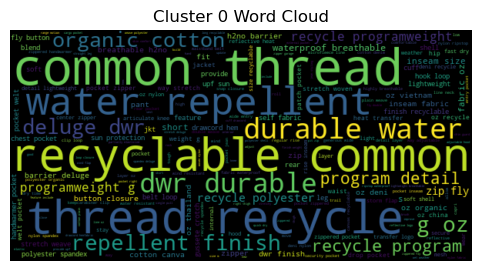

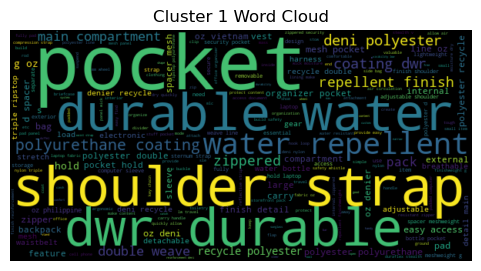

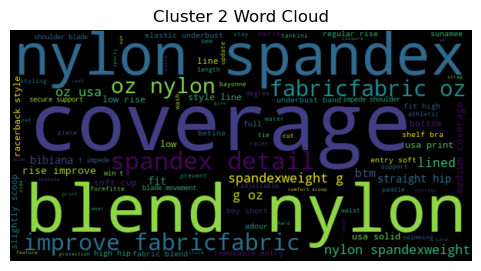

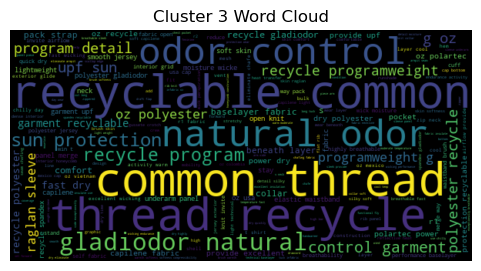

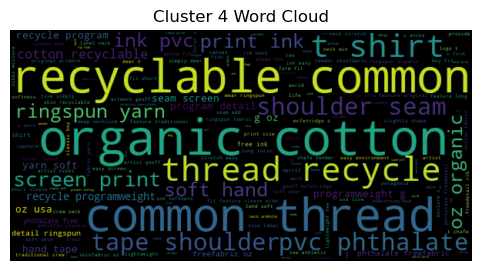

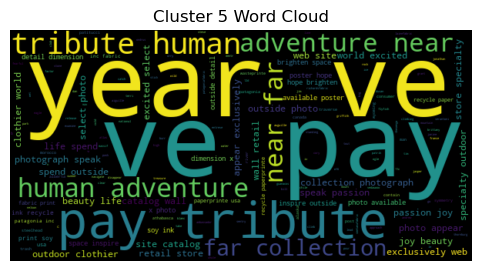

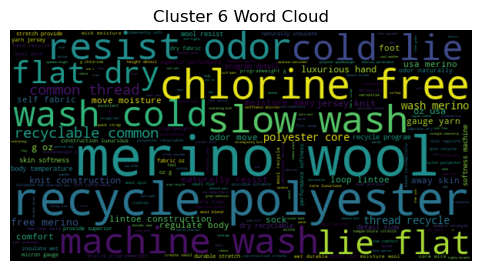

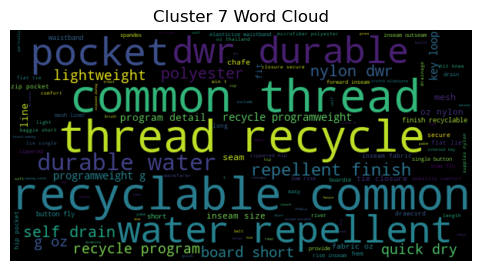

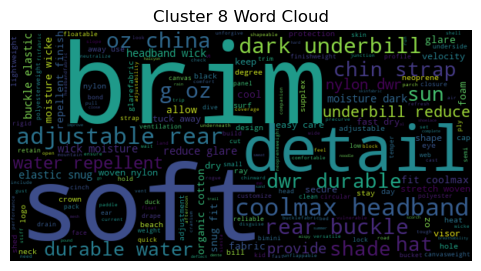

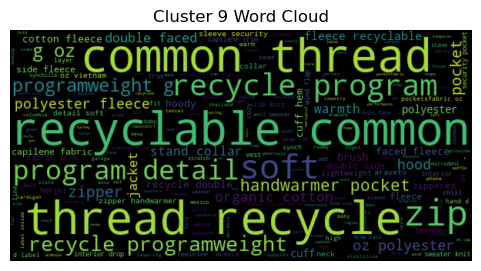

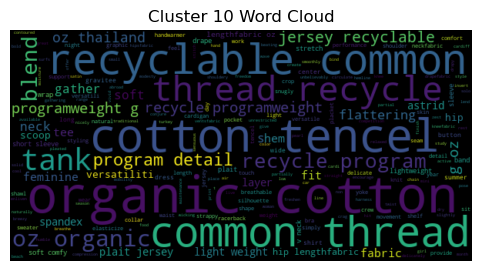

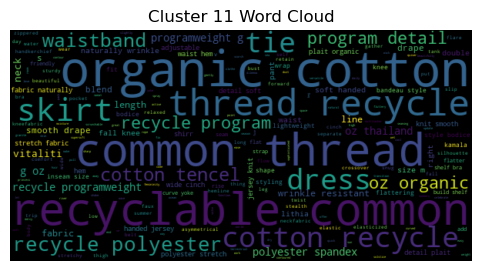

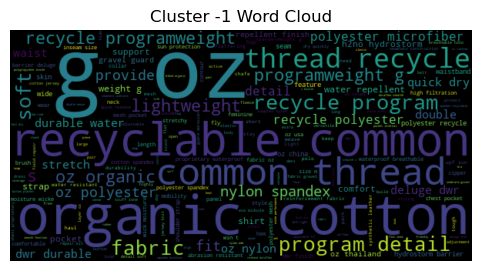

In [13]:
import wordcloud
from wordcloud import WordCloud

# Loop over each cluster
for cluster_id in set(labels):
    # Filter the documents belonging to the current cluster
    cluster_documents = df[df["cluster"] == cluster_id]["nlp_ready"]
    
    # Concatenate all the documents into a single string
    cluster_text = " ".join(cluster_documents)
    
    # Generate a word cloud for the cluster
    wordcloud = WordCloud(width=600, height=300).generate(cluster_text)
    
    # Display the word cloud
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_id} Word Cloud')
    plt.show()

### Part 2 - Recommender system

In [14]:
def find_similar_items(item_id):
    # Get the cluster ID of the given item
    mask1 = df["id"] == item_id
    item_cluster = df.loc[mask1, "cluster"].values[0]

    # Get all items belonging to the same cluster
    mask2 = df["cluster"] == item_cluster
    cluster_items = df.loc[mask2, "id"]

    # Remove the given item from the list of cluster items
    cluster_items = cluster_items.loc[cluster_items != item_id]

    # Return a list of similar items
    similar_items = cluster_items.sample(n=5, random_state=42).tolist()
    return similar_items

In [15]:
# Take user input for the item ID
user_item_id = input("Enter the item ID you're interested in: ")

# Display the recommendations
print("Recommended similar items:", find_similar_items(int(user_item_id)))

Recommended similar items: [243, 358, 30, 195, 132]


### Part 3 : Topic modeling

In [16]:
# Use the TruncatedSVD model in order to create a topic model with 20 different topics
svd_model = TruncatedSVD(n_components=20, n_iter=100, random_state=42)
lsa = svd_model.fit_transform(X)

col_names = []
for x in range(1, 21) :
    c = "topic_" + str(x)
    col_names.append(c)
    x+=1

topic_encoded_df = pd.DataFrame(lsa, columns = col_names)
topic_encoded_df["text"] = df["nlp_ready"]
topic_encoded_df

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0    0.277490 -0.047739  0.183826  0.083828 -0.124879 -0.007273 -0.045942   
1    0.274574 -0.072586  0.096122  0.099769 -0.019503  0.088766 -0.051105   
2    0.258228 -0.086581  0.107227  0.023948 -0.026217  0.088671  0.015290   
3    0.386689 -0.248901 -0.120191 -0.141196  0.049189 -0.015145 -0.023190   
4    0.395885 -0.259814 -0.030567 -0.233244 -0.033068 -0.027504  0.042134   
..        ...       ...       ...       ...       ...       ...       ...   
495  0.329844 -0.080397  0.389643  0.065363 -0.263211 -0.030972 -0.022322   
496  0.372376 -0.083371  0.487059 -0.009116 -0.303071 -0.034539  0.013100   
497  0.341204 -0.214003 -0.067430 -0.259051 -0.006912 -0.150918  0.143922   
498  0.328928  0.059213 -0.127822  0.320303  0.024095 -0.122166 -0.106372   
499  0.377750  0.059713 -0.182942  0.346016  0.015928 -0.138349 -0.099806   

      topic_8   topic_9  topic_10  ...  topic_12  topic_13  topic_14  \
0   -0.022091 -0.150383  0.016390  ...  0.057324 -0.029509  0.028273   
1   -0.027253 -0.106732 -0.066866  ...  0.196279  0.016715  0.054575   
2    0.044467 -0.049291 -0.017626  ...  0.207135  0.059991  0.066632   
3   -0.040872 -0.061127 -0.147385  ...  0.101888 -0.165789 -0.038148   
4    0.062043  0.017021 -0.193898  ... -0.001573 -0.193654  0.284557   
..        ...       ...       ...  ...       ...       ...       ...   
495 -0.100676 -0.336402  0.060878  ...  0.031960 -0.072946  0.003633   
496 -0.013590 -0.237631  0.131194  ... -0.065845 -0.103688  0.078461   
497 -0.162117  0.060176  0.021260  ... -0.115046  0.091235 -0.039666   
498 -0.004272 -0.091885  0.038522  ... -0.124174  0.080579  0.090346   
499  0.003570 -0.077101  0.030692  ... -0.144239  0.059633  0.069019   

     topic_15  topic_16  topic_17  topic_18  topic_19  topic_20  \
0    0.038625  0.024372 -0.061255 -0.032076  0.019086  0.001789   
1   -0.070250  0.048511  0.092602 -0.036723  0.047819  0.006139   
2   -0.063148  0.015545  0.086867 -0.013883  0.067192 -0.027176   
3    0.044303 -0.018895 -0.002800  0.059414  0.249027  0.025576   
4    0.050462 -0.005975 -0.075135  0.002814 -0.032744 -0.027790   
..        ...       ...       ...       ...       ...       ...   
495 -0.012606  0.021675 -0.095756  0.016727  0.047090  0.085411   
496 -0.074154  0.074767 -0.033070 -0.041959 -0.005131  0.147871   
497 -0.009659  0.000408 -0.020487 -0.004937 -0.005915 -0.007581   
498 -0.088153 -0.040531  0.050025  0.155568 -0.208861  0.132593   
499 -0.027400 -0.027403  0.039639  0.120550 -0.162330  0.078552   

                                                  text  
0    active classic boxer s reason boxer cult favor...  
1    active sport boxer brief skin glory require mo...  
2    active sport brief superbreathable fly brief m...  
3    alpine guide pant skin climb ice switch rock t...  
4    alpine wind jkt high ridge steep ice alpine ja...  
..                                                 ...  
495  cap 2 bottom cut loose madden crowd search und...  
496  cap 2 crew crew take edge fickle weather clear...  
497  time shell need use morning time umbrella time...  
498  wear cargo short wear cargo short bask glory s...  
499  wear short time simplify wear short prove shor...  

[500 rows x 21 columns]

In [17]:
# Assign each document to the topic it is the most linked to
topic_encoded_df["class_pred"] = [np.argmax(topic) for topic in lsa]
topic_encoded_df["class_pred"].value_counts()

0     263
1      61
2      35
7      26
5      24
8      16
3      15
4      12
6      12
12     10
10      8
14      7
11      3
19      3
16      3
9       1
15      1
Name: class_pred, dtype: int64

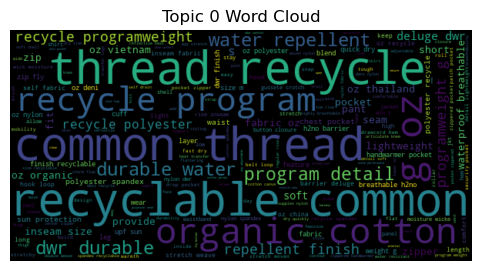

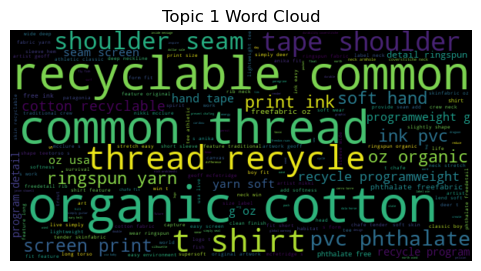

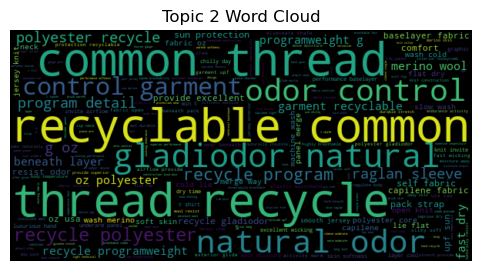

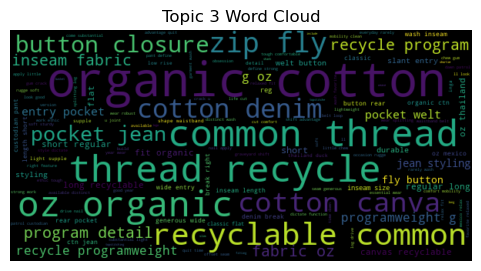

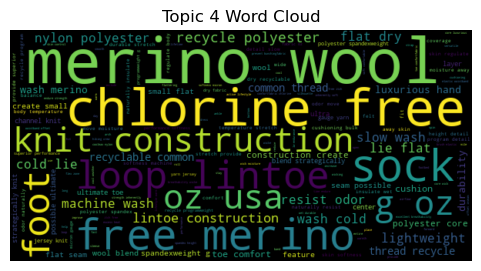

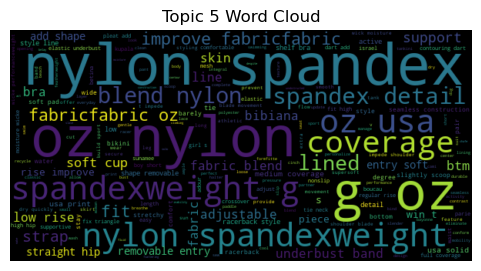

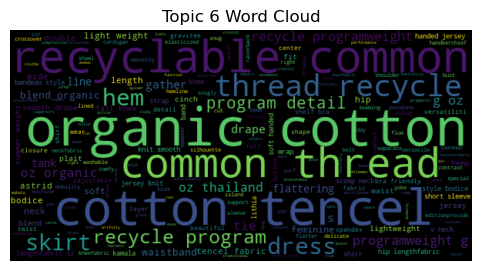

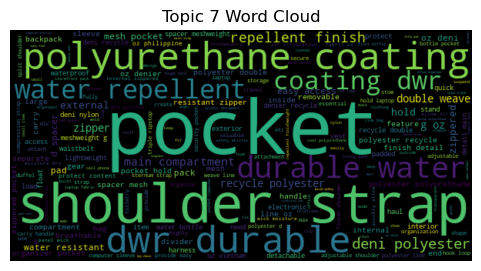

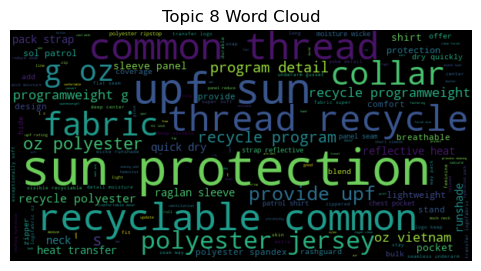

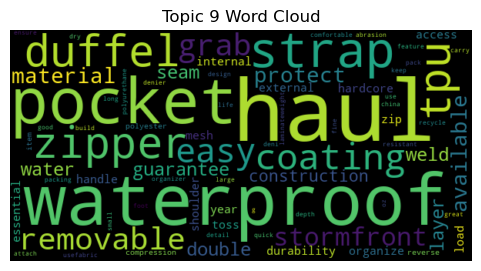

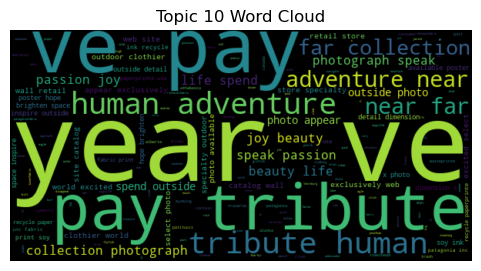

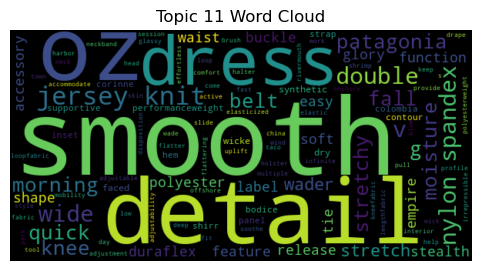

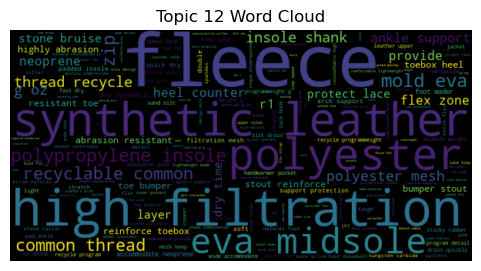

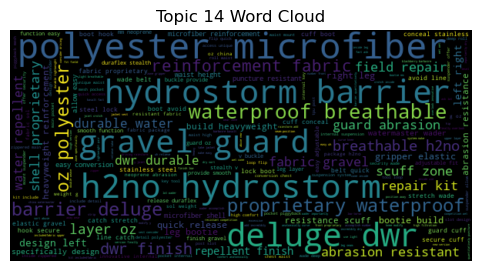

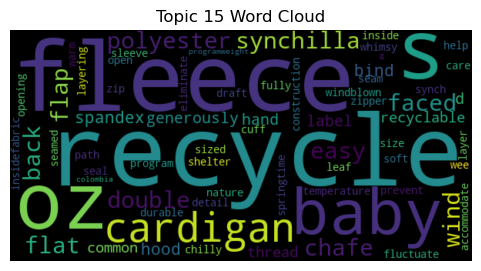

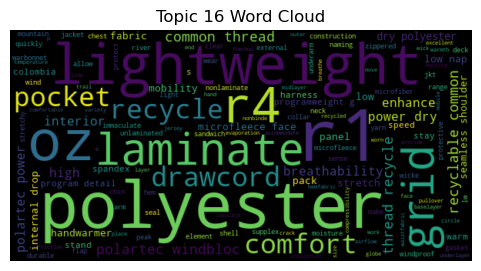

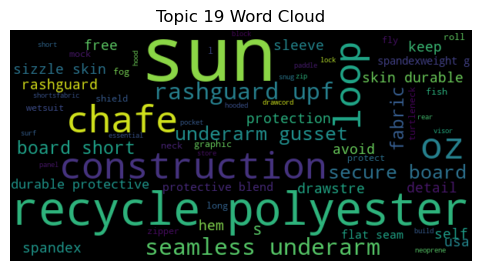

In [19]:
labels = topic_encoded_df["class_pred"]

# Loop over each topic
for topic_id in set(labels):
    # Filter the documents belonging to the current topic
    topic_documents = topic_encoded_df[topic_encoded_df["class_pred"] == topic_id]["text"]
    
    # Concatenate all the documents into a single string
    topic_text = " ".join(topic_documents)
    
    # Generate a word cloud for the topic
    wordcloud = WordCloud(width=600, height=300).generate(topic_text)
    
    # Display the word cloud
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id} Word Cloud')
    plt.show()